In [1]:
'''
Dandan Wei
Jan 19, 2022

This script analyze the EVI in NYC area using the land cover data
Input dataset:
        EVI_all (the raw EVI data for 2021)
        EVI_all_intp_row2411760 (the interpolated EVI for the year of 2021)
        nlcd_epsg32618_cropped.tif (the NLCD data for NYC area)
Outputs:
        Some figures to show the EVI characteristics in NYC area

'''

import gdal, ogr, osr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import rasterio
import math
import pandas as pd
from datetime import datetime
import glob
import time
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

DataDir = "/data0/dwei/VPRMdata/"
FigDir  = "/data0/dwei/temp/"

NLCDfile= "nlcd_epsg32618_cropped.tif"
EVIfile = "EVI_all_intp_row2411760"

# NLCD legends 
# NLCD have 2.4% zeros (not sure what it means)
Legend_nlcd = {"Open water": 11, 
               "Ice-snow"  : 12,\
               "Developed open space": 21,\
               "Developed_low": 22,\
               "Developed_medium": 23,\
               "Developed_high": 24,\
               "Barren land": 31,\
               "Deciduous forest": 41,\
               "Evergreen forest": 42,\
               "Mixed forest": 43,\
               "Dwarf scrub": 51,\
               "Shrub": 52,\
               "Grassland":71,\
               "Sedge": 72,\
               "Lichens": 73,\
               "Moss":74,\
               "Pasture-hay": 81,\
               "Crops": 82,\
               "Woody wetland": 90,\
               "herbaceous wetland": 95}

# Read the NLCD files
NLCD_rast = rasterio.open(DataDir+NLCDfile)
NLCD_2D = NLCD_rast.read(1)
NLCD_1D = np.reshape(NLCD_2D, np.size(NLCD_2D)) 

# # The Geocoordinates X,Y from a random EVI time series file
# EVITSfile = glob.glob(DataDir+EVIfile)
# EVITS = pd.read_csv(EVITSfile[0])
# EVI_X = EVITS["X"]
# EVI_Y = EVITS["Y"]

# The interpolated EVI and LSWI
start_time = time.time()
EVI_df = pd.read_csv(DataDir + EVIfile) 
EVI = EVI_df.to_numpy()
EVI=EVI[:, 1:] # the first column is not EVI

print("--- %s minutes ---" % (time.time()/60 - start_time/60))


--- 1.7199858874082565 minutes ---


/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/opt/sw/anaconda3/envs/GDAL+/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


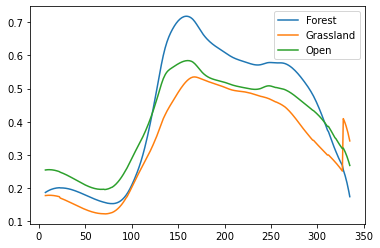

In [2]:
# Calculate the start and end of growing season (SOS, EOS)
# Zhang et al., 2003, Monitoring vegetation phenology using MODIS
def get_EVI_for_one_landcover(lc):
    # A specific land cover type
    boo_lc=NLCD_1D==lc
    return EVI[boo_lc, :]

# DBF
EVI_for_ave = np.nanmean(get_EVI_for_one_landcover(41), axis=0)
EVI_for_std = np.nanstd(get_EVI_for_one_landcover(41), axis=0)
# Grassland
EVI_grs_ave = np.nanmean(get_EVI_for_one_landcover(71), axis=0)
EVI_grs_std = np.nanstd(get_EVI_for_one_landcover(71), axis=0)
# Low dev
EVI_lde_ave = np.nanmean(get_EVI_for_one_landcover(22), axis=0)
EVI_lde_std = np.nanstd(get_EVI_for_one_landcover(22), axis=0)
# Medium dev
EVI_mde_ave = np.nanmean(get_EVI_for_one_landcover(23), axis=0)
EVI_mde_std = np.nanstd(get_EVI_for_one_landcover(23), axis=0)
# High dev
EVI_hde_ave = np.nanmean(get_EVI_for_one_landcover(24), axis=0)
EVI_hde_std = np.nanstd(get_EVI_for_one_landcover(24), axis=0)
# Open space
EVI_ope_ave = np.nanmean(get_EVI_for_one_landcover(21), axis=0)
EVI_ope_std = np.nanstd(get_EVI_for_one_landcover(21), axis=0)

DOY = np.arange(1, 366)

plt.figure()
plt.errorbar(DOY, EVI_for_ave, yerr=None, label='Forest')
plt.errorbar(DOY, EVI_grs_ave, yerr=None, label='Grassland')
# plt.errorbar(DOY, EVI_lde_ave, yerr=None, label='Low')
# plt.errorbar(DOY, EVI_mde_ave, yerr=None, label='Medium')
# plt.errorbar(DOY, EVI_hde_ave, yerr=None, label='High')
plt.errorbar(DOY, EVI_ope_ave, yerr=None, label='Open')
plt.legend()


In [51]:
# Fitting 
# Had to scale DOY down
# The SOS and EOS have to be done separately
scalingDOY = 0.01
sday = 0
eday = 180 # June 30, 2021
EVI_fit_sp = EVI_for_ave[sday:eday]      # EVI
DOY_fit_sp = DOY[sday:eday]*scalingDOY   # DOY
nans = np.isnan(EVI_fit_sp)              # remove NaNs
EVI_fit_sp = EVI_fit_sp[~nans]
DOY_fit_sp = DOY_fit_sp[~nans]

EVI_fit_au = EVI_for_ave[eday:]      # EVI
DOY_fit_au = DOY[eday:]*scalingDOY   # DOY
nans = np.isnan(EVI_fit_au)          # remove NaNs
EVI_fit_au = EVI_fit_au[~nans]
DOY_fit_au = DOY_fit_au[~nans]

print(np.shape(DOY_fit_sp))
print(np.shape(DOY_fit_au))


(174,)
(155,)


Fitted parameters: [ 15.494436   -12.63430053   0.52598008   0.17772659]


RMSE: 0.017405014242312673
R-squared: 0.9938346805625203



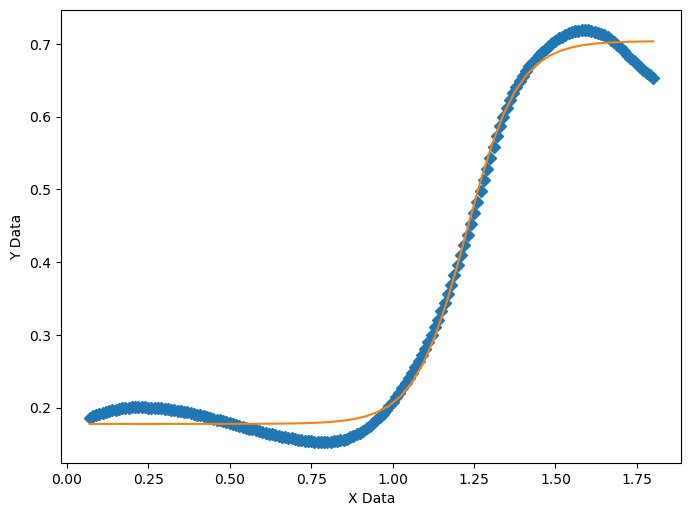

Fitted parameters: [-14.63969973   4.3896849    0.81383717  -0.20890494]


RMSE: 0.014332222869440098
R-squared: 0.9847490355959132



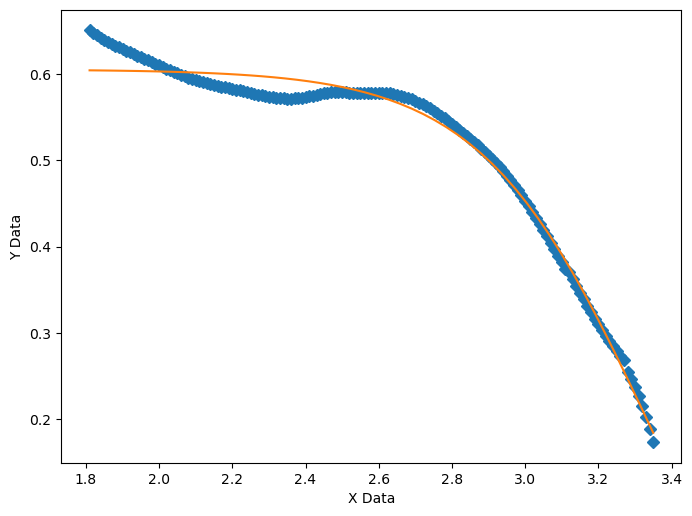

In [52]:
# Show case how to add constrains on fitting parameters to make fitting converge
# Changed into a function

def func(DOY, a, b, c, d):
    return d + np.divide(c, 1+np.exp(a+b*DOY))
    
def get_fitting_parameters(xData,yData):
    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(xData, *parameterTuple)
        return np.sum((yData - val) ** 2.0)

    def generate_Initial_Parameters():
        minY = min(yData)
        maxY = max(yData)

        parameterBounds = []
        parameterBounds.append([1.0, 15.0]) # search bounds for a
        parameterBounds.append([1.0, 15.0]) # search bounds for b
        parameterBounds.append([maxY-minY, maxY]) # search bounds for c
        parameterBounds.append([0, minY])   # search bounds for d

        # "seed" the numpy random number generator for repeatable results
        result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    # by default, differential_evolution completes by calling curve_fit() using parameter bounds
    geneticParameters = generate_Initial_Parameters()

    # now call curve_fit without passing bounds from the genetic algorithm,
    # just in case the best fit parameters are aoutside those bounds
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
    print('Fitted parameters:', fittedParameters)
    print()

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    print()
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    print()

    ##########################################################
    # graphics output section
    def ModelAndScatterPlot(graphWidth, graphHeight):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
        axes = f.add_subplot(111)

        # first the raw data as a scatter plot
        axes.plot(xData, yData,  'D')

        # create data for the fitted equation plot
        xModel = np.linspace(min(xData), max(xData))
        yModel = func(xModel, *fittedParameters)

        # now the model as a line plot
        axes.plot(xModel, yModel)

        axes.set_xlabel('X Data') # X axis data label
        axes.set_ylabel('Y Data') # Y axis data label

        plt.show()
        plt.close('all') # clean up after using pyplot

    graphWidth = 800
    graphHeight = 600
    ModelAndScatterPlot(graphWidth, graphHeight)
    return fittedParameters

def get_Sprint_prime(DOY_fit, fittedParameters):
    c = fittedParameters[2]
    d = fittedParameters[3]
    a = fittedParameters[0]
    b = fittedParameters[1]
    z = np.exp(a+b*DOY_fit)
    return -np.divide(b**2*c*z*(1-z)*(1+z)**3, ((1+z)**4+(b*c*z)**2)**(3/2))

# Spring
fittedParam_sp = get_fitting_parameters(DOY_fit_sp, EVI_fit_sp)
xModel_sp = DOY_fit_sp
yModel_sp = func(xModel_sp, *fittedParam_sp)
# Autumn
fittedParam_au = get_fitting_parameters(DOY_fit_au, EVI_fit_au)
xModel_au = DOY_fit_au
yModel_au = func(xModel_au, *fittedParam_au)
# Rate of change
Sprint_prime_sp = get_Sprint_prime(DOY_fit_sp, fittedParam_sp)
Sprint_prime_au = get_Sprint_prime(DOY_fit_au, fittedParam_au)


SOS and EOS are 105, 293, respectively


Text(0, 0.5, 'Rate of change of EVI')

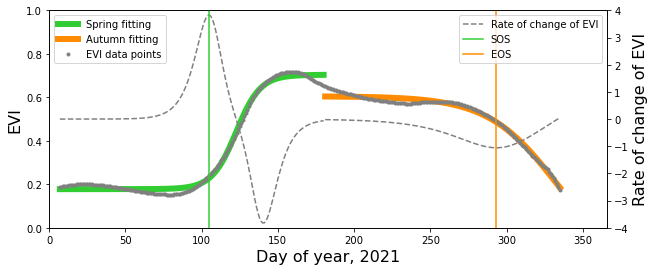

In [57]:
SOS = DOY_fit_sp[Sprint_prime_sp==max(Sprint_prime_sp)]/scalingDOY
EOS = DOY_fit_au[Sprint_prime_au==min(Sprint_prime_au)]/scalingDOY
print('SOS and EOS are %d, %d, respectively' %(int(SOS),int(EOS)))
FontSize = 16
LineWidth=6

fig, ax=plt.subplots(1, figsize=(10,4))
ax.plot(xModel_sp/scalingDOY, yModel_sp, '-', label='Spring fitting', 
        linewidth=LineWidth, color='limegreen')
ax.plot(xModel_au/scalingDOY, yModel_au, '-', label='Autumn fitting', 
        linewidth=LineWidth ,color='darkorange')
ax.plot(xModel_sp/scalingDOY, EVI_fit_sp, '.', label='EVI data points', 
        color='grey', linewidth=LineWidth) 
ax.plot(xModel_au/scalingDOY, EVI_fit_au, '.', label='',
        color='grey', linewidth=LineWidth) 
ax.legend(loc='upper left')
ax.set_xlim(0, 366)
ax.set_ylim(0,1)
ax.set_ylabel('EVI', fontsize=FontSize)
ax.set_xlabel('Day of year, 2021', fontsize=FontSize)

ax1=ax.twinx()
ax1.plot(DOY_fit_sp/scalingDOY, Sprint_prime_sp, '--', 
         label='', color='gray')
ax1.plot(DOY_fit_au/scalingDOY, Sprint_prime_au, '--', 
         label='Rate of change of EVI', color='gray')
ax1.plot([SOS, SOS], [-40,40], '-', color='limegreen', label='SOS')
ax1.plot([EOS, EOS], [-40,40], '-', color='darkorange', label='EOS')
ax1.legend(loc='upper right')
ax1.set_ylim(-4,4)
ax1.set_ylabel('Rate of change of EVI', fontsize=FontSize)


In [ ]:
start_time = time.time()

# Percentage of each land cover type
# Seasonality of EVI_intp for each land cover type
Percentage = []
n_pixel    = []            # pixel NO. for each type
EVI_pxl    = np.empty((len(Legend_nlcd), 365))
EVI_pxl[:] = np.nan
LSWI_pxl   = np.empty((len(Legend_nlcd), 365))
LSWI_pxl[:]= np.nan
tot_pixels = np.size(NLCD) # total pixel number

i = 0
for key, val in Legend_nlcd.items():
    
    print("======= Looping through %s =========" %(key))
    
    ind = [pix for pix in NLCD if pix==val]
    p   = np.size(ind)/tot_pixels
    n_pixel.append(np.size(ind))
    Percentage.append(p)
    print("Percent is %3.0f %%" %(p*100))
    print("Number of pixels are %3.0f" %(np.size(ind)))
    
    # EVI and LSWI
    pixel_ind    = [pix==val for pix in NLCD]
    EVI_pxl[i,:] = np.nanmean(EVI[pixel_ind, 1:], axis=0) # there are 366 columns in EVI
    LSWI_pxl[i,:]= np.nanmean(LSWI[pixel_ind, 1:],axis=0) # there are 366 columns in LSWI
    
    i+=1
        
    print("======= End of loop %s =========" %(key))
    print("\n\n")

print("--- %s minutes ---" % (time.time()/60 - start_time/60))


In [ ]:
# plot the EVI and LSWI for each pixel
dates   = [datetime.strptime("2021"+str(d), "%Y%j").strftime("%m-%d-%Y") \
       for d in range(1, 366)] # Jun 1 to Aug 31
legends = list(Legend_nlcd.keys())

[fig, ax] = plt.subplots(5, 4, figsize=(15, 15))
i = 0
for i, axis in enumerate(ax.flat):
    axis.plot(dates, EVI_pxl[i, :])
    if (i+1)%4==1:
        axis.set_ylabel("EVI")
    axis.set_ylim(0, 1.0)
    
    axis.text(0.98, 0.90, legends[i],
        verticalalignment='bottom', horizontalalignment='right',
        transform=axis.transAxes, fontsize=12)
    
    axis.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 1)))
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    axis.grid(True)
    i+=1

plt.show()
fig.savefig(FigDir_temp + 'EVI_for_each_land_cover')

# plot the seasonality for each pixel
[fig, ax] = plt.subplots(5, 4, figsize=(15, 15))
i = 0
for i, axis in enumerate(ax.flat):
    axis.plot(dates, LSWI_pxl[i, :])
    if (i+1)%4==1:
        axis.set_ylabel("LSWI")
    axis.set_ylim(-0.1, 0.3)
    
    axis.text(0.98, 0.90, legends[i],
        verticalalignment='bottom', horizontalalignment='right',
        transform=axis.transAxes, fontsize=12)
    
    axis.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 1)))
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    axis.grid(True)
    i+=1

plt.show()
fig.savefig(FigDir_temp + 'LSWI_for_each_land_cover')

In [ ]:
# plot the percentages of each land cover type
[fig, axis] = plt.subplots(1, figsize=(20, 5))
axis.bar(legends, [p*100.0 for p in Percentage])  
axis.set_ylim(0, 30)
axis.set_ylabel("Percent (%)", fontsize=20)
axis.tick_params(axis='x', labelrotation = 90, labelsize=24)
axis.grid(True)

plt.show()
fig.savefig(FigDir_temp + 'Percent_land_cover_type')